# Laboratorium 8 - Podstawowe transformacje geometryczne

W ramach laboratorium zostaną zaimplementowane podstawowe sposoby transformacji geomerycznych obrazu: transformacja sztywna oraz transformacja oparta o tzw. gęste pole deformacji.
Zostanie również zaimplementowana własna funkcja do interpolacji dwuliniowej.

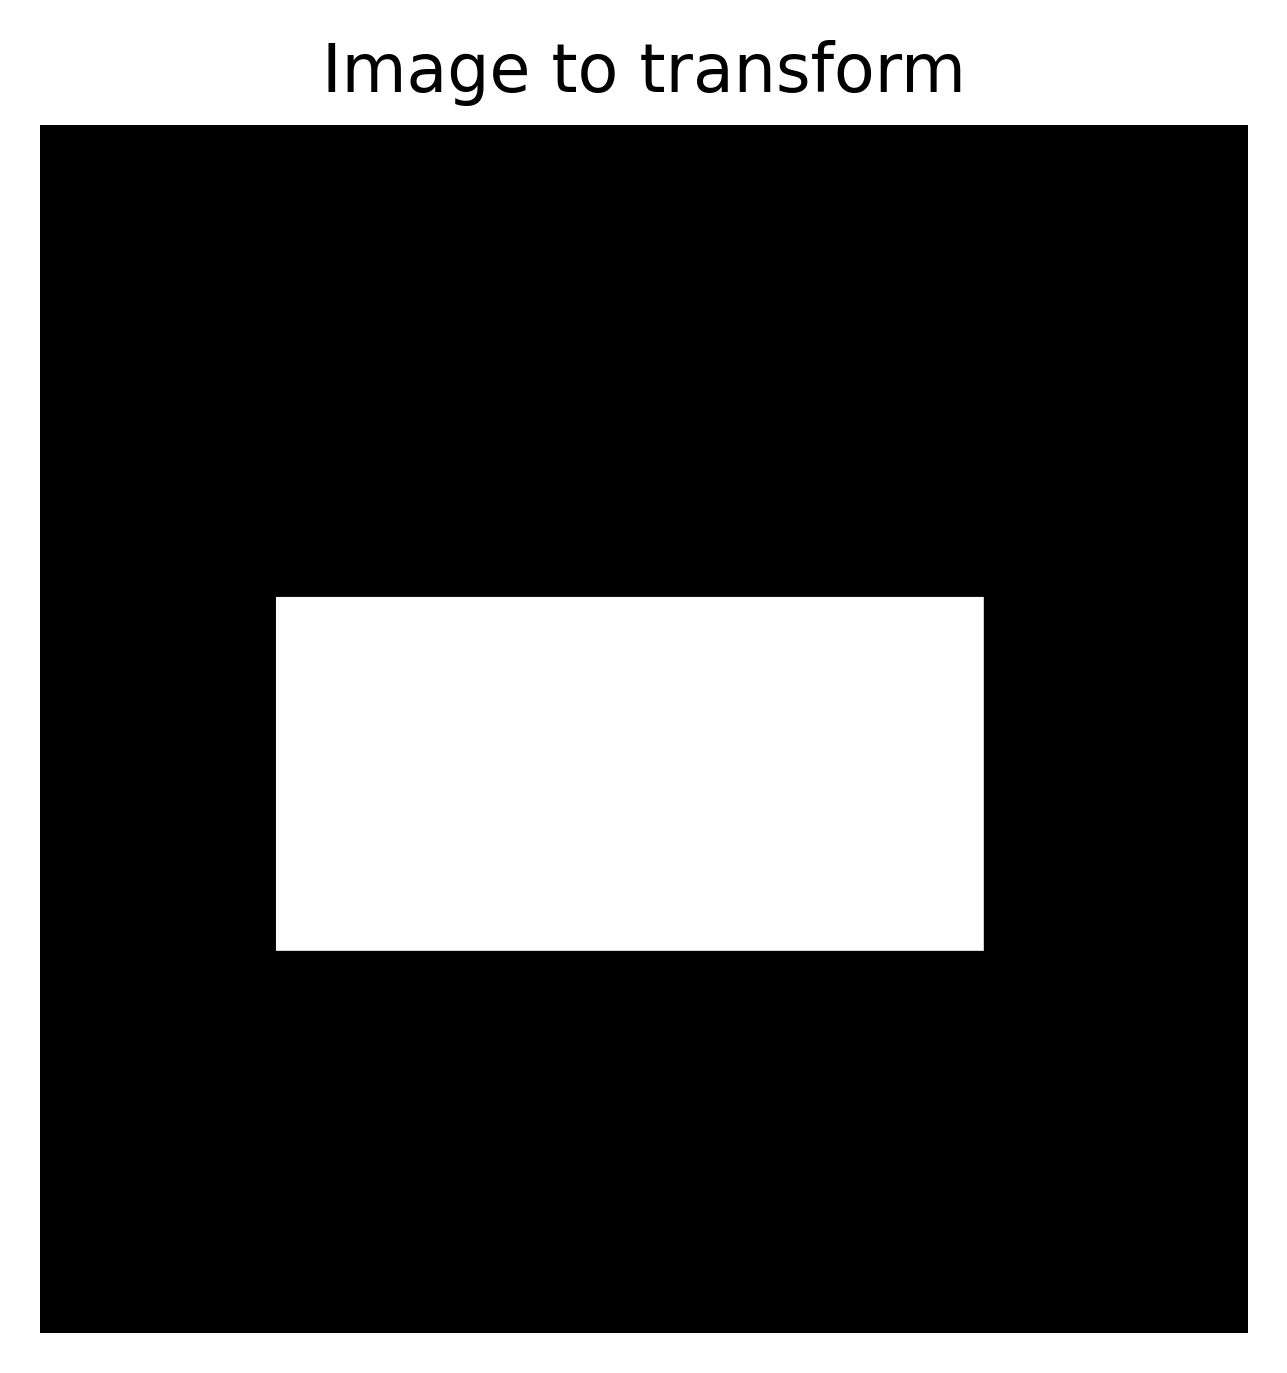

In [27]:
import numpy as np
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
%matplotlib inline

y_size, x_size = 1024, 1024
image = np.zeros((y_size, x_size))
image[400:700, 200:800] = 1
plt.figure(dpi=200)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image to transform")
plt.show()

Pierwszym zadaniem jest implementacja funkcji generującej macierz transformacji sztywnej (0.5p). Przyjmij, żę generujemy macierz homogeniczną 3x3, a nie oddzielną macierz rotacji i wektor translacji.

In [28]:
def gen_rigid_matrix(xt, yt, rot):
    """
    xt - translacja po kolumnach
    yt - translacja po wierszach
    rot - rotacja (w stopniach)
    """
    # TO DO
    matrix1 =np.array ([[1,0,xt],
              [0,1,yt],
              [0,0,1]])
    rot=rot*np.pi/180
    sin=np.sin(rot)
    cos=np.cos(rot)
    
    
    angle_mat=np.array([[cos,-sin,0],
              [sin,cos,0],
              [0,0,1]])
    
    multiplication = matrix1.dot(angle_mat)
    
    return multiplication

Przykładowy wynik działania funkcji:

In [31]:
rigid_matrix = gen_rigid_matrix(50, 50, 45)
#print("Rigid matrix: ")
#print(rigid_matrix)

Kolejnym krokiem jest implementacja funkcji do transformacji sztywnej (1p).

Funkcja będzie potrzebowała dwóch funkcji pomocnicznych:

1) Funkcji, która będzie modyfikować wygenerowaną macierz transformacji tak, aby następowała ona względem środka obrazu.

2) Funkcji, która dokona transformacji geometrycznej koordynatów korzystając z wycentrowanej macierzy transformacji sztywnej.

Na ten moment do interpolacji wykorzystaj gotową funkcje z pakietu scipy.ndimage.

In [32]:
def center_matrix(transform, x_size, y_size):
    """
    transform - macierz transformacji sztywnej (3x3)
    x_size - liczba kolumn obrazu
    y_size = liczba wierszy obrazu
    """
    x=x_size//2
    y=y_size//2
    
    matrix = np.array([[1,0,x],
                      [0,1,y],
                      [0,0,1]])
    
    multiplication = np.dot(matrix, transform)
    
    matrix_xd=  np.array([[1,0,-x],
                      [0,1,-y],
                      [0,0,1]])
    multiplication = np.dot(multiplication, matrix_xd)
    return multiplication

In [33]:
def rigid_dot(grid_x, grid_y, transform):
    """
    grid_x - siatka po kolumnach (YxX)
    grid_y - siatka po wierszach (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """
    new_grid_x = np.zeros(grid_x.shape)
    new_grid_y = np.zeros(grid_y.shape)
    for i in range (grid_x.shape[0]):
        for j in range(grid_y.shape[1]):
            vect = np.array([grid_x[i][j], grid_y[i][j], 1])
            new_grid_x[i][j], new_grid_y[i][j],_ = np.dot(transform,vect)

    return new_grid_x, new_grid_y

In [34]:
def rigid_transform(image, transform):
    """
    image - obraz do transformacji (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """
    M,N = image.shape

    center = center_matrix(transform,M,N)

    grid_x = np.zeros((M,N))
    grid_y = np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            grid_x[j][i]=j
            grid_y[i][j]=j

    print(grid_x, grid_y)
    rigid_x, rigid_y = rigid_dot(grid_x,grid_y,center)

    transofmed = nd.map_coordinates(image,(rigid_x,rigid_y))
    return transofmed

Wyniki działania poszczególnych kroków:

Przektszałcenie macierzy względem środka obrazu:

In [35]:
centered_matrix = center_matrix(rigid_matrix, x_size, y_size)
print("Centered rigid matrix: ")
print(centered_matrix)

Centered rigid matrix: 
[[   0.70710678   -0.70710678  562.        ]
 [   0.70710678    0.70710678 -162.07734394]
 [   0.            0.            1.        ]]


Transformacja koordynatów za pomocą macierzy sztywnej:

In [36]:
grid_x = np.array([
    [0, 1, 2],
    [0, 1, 2],
    [0, 1, 2]
])
grid_y = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [2, 2, 2]
])
temp_transform = np.array([
    [1, 0, 1],
    [0, 1, -1],
    [0, 0, 0]
])

new_grid_x, new_grid_y = rigid_dot(grid_x, grid_y, temp_transform)
print("Transformed grids: ")
print(new_grid_x)
print(new_grid_y)

Transformed grids: 
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]


Rezultat transformacji sztywnej:

[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]
 [2.000e+00 2.000e+00 2.000e+00 ... 2.000e+00 2.000e+00 2.000e+00]
 ...
 [1.021e+03 1.021e+03 1.021e+03 ... 1.021e+03 1.021e+03 1.021e+03]
 [1.022e+03 1.022e+03 1.022e+03 ... 1.022e+03 1.022e+03 1.022e+03]
 [1.023e+03 1.023e+03 1.023e+03 ... 1.023e+03 1.023e+03 1.023e+03]] [[0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 ...
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]]


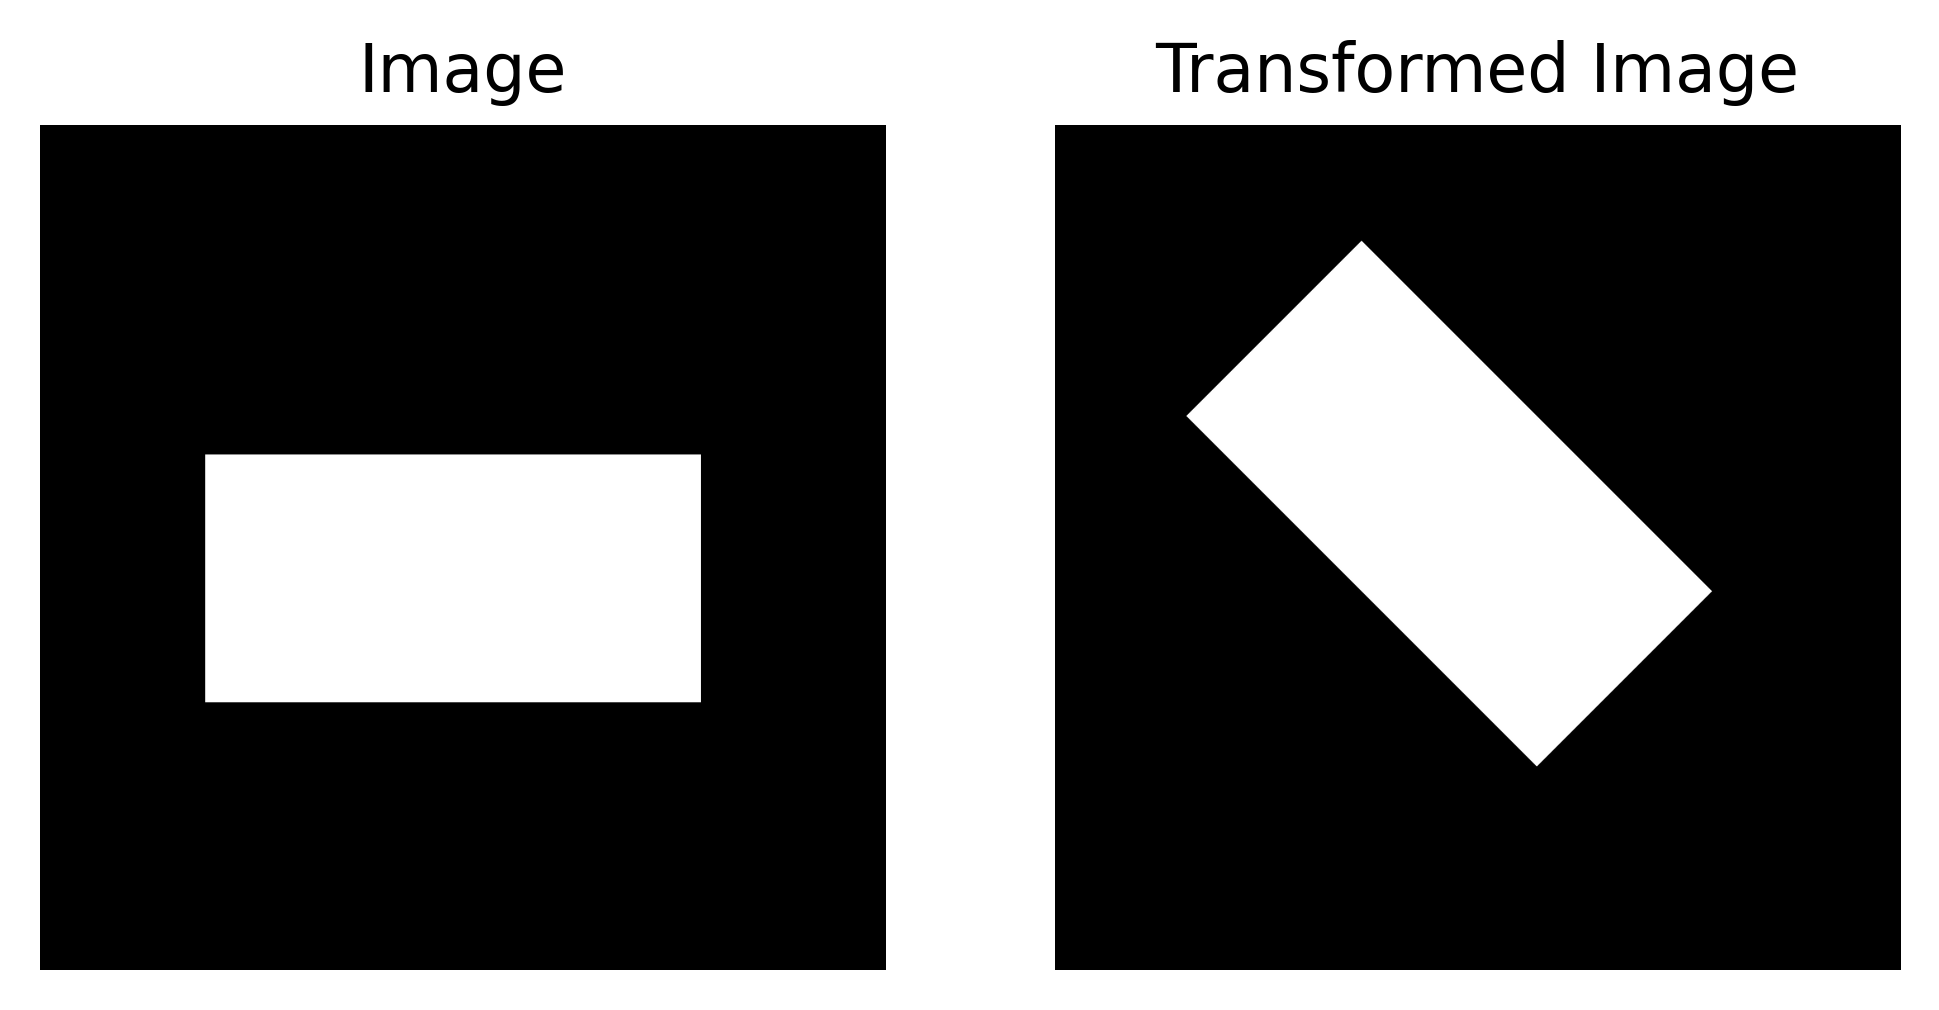

In [37]:
transformed_image = rigid_transform(image, rigid_matrix)
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image")
plt.show()

Kolejnym zadaniem jest implementacja własnej funkcji do interpolacji dwuliniowej (1p). Nie korzystaj z gotowych funkcji do interpolacji. Napisz funkcje samodzielnie korzystając jedynie z podstawowych operacji.

In [38]:
def interpolate_2d(image, grid_x, grid_y):
    """
    image - obraz do interpolacji (YxX)
    grid_x - siatka kolumn (YxX)
    grid_y - siatka wierszy (YxX)
    """
    grid_x = np.asarray(grid_x)
    grid_y = np.asarray(grid_y)

    x0 = np.floor(grid_x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(grid_y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, image.shape[1]-1);
    x1 = np.clip(x1, 0, image.shape[1]-1);
    y0 = np.clip(y0, 0, image.shape[0]-1);
    y1 = np.clip(y1, 0, image.shape[0]-1);

    Ia = image[ y0, x0 ]
    Ib = image[ y1, x0 ]
    Ic = image[ y0, x1 ]
    Id = image[ y1, x1 ]

    wa = (x1-grid_x) * (y1-grid_y)
    wb = (x1-grid_x) * (grid_y-y0)
    wc = (grid_x-x0) * (y1-grid_y)
    wd = (grid_x-x0) * (grid_y-y0)

    image = wa*Ia + wb*Ib + wc*Ic + wd*Id
    return image

Po implementacji zastąp funkcje do interpolacji wykorzystaną w wcześniejszej wersji funkcji rigid_transform. Wynik powinien być identyczny.

In [39]:
def rigid_transform_my_interpolation(image, transform):
    """
    image - obraz do transformacji (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """
    M,N = image.shape

    center = center_matrix(transform,M,N)

    grid_x = np.zeros((M,N))
    grid_y = np.zeros((M,N))

    for i in range(M):
        for j in range(N):
            grid_x[j][i]=j
            grid_y[i][j]=j

    
    rigid_x, rigid_y = rigid_dot(grid_x,grid_y,center)
    
    rigid_trans = interpolate_2d(image,rigid_y, rigid_x)
    return rigid_trans

[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]
 [2.000e+00 2.000e+00 2.000e+00 ... 2.000e+00 2.000e+00 2.000e+00]
 ...
 [1.021e+03 1.021e+03 1.021e+03 ... 1.021e+03 1.021e+03 1.021e+03]
 [1.022e+03 1.022e+03 1.022e+03 ... 1.022e+03 1.022e+03 1.022e+03]
 [1.023e+03 1.023e+03 1.023e+03 ... 1.023e+03 1.023e+03 1.023e+03]] [[0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 ...
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]
 [0.000e+00 1.000e+00 2.000e+00 ... 1.021e+03 1.022e+03 1.023e+03]]


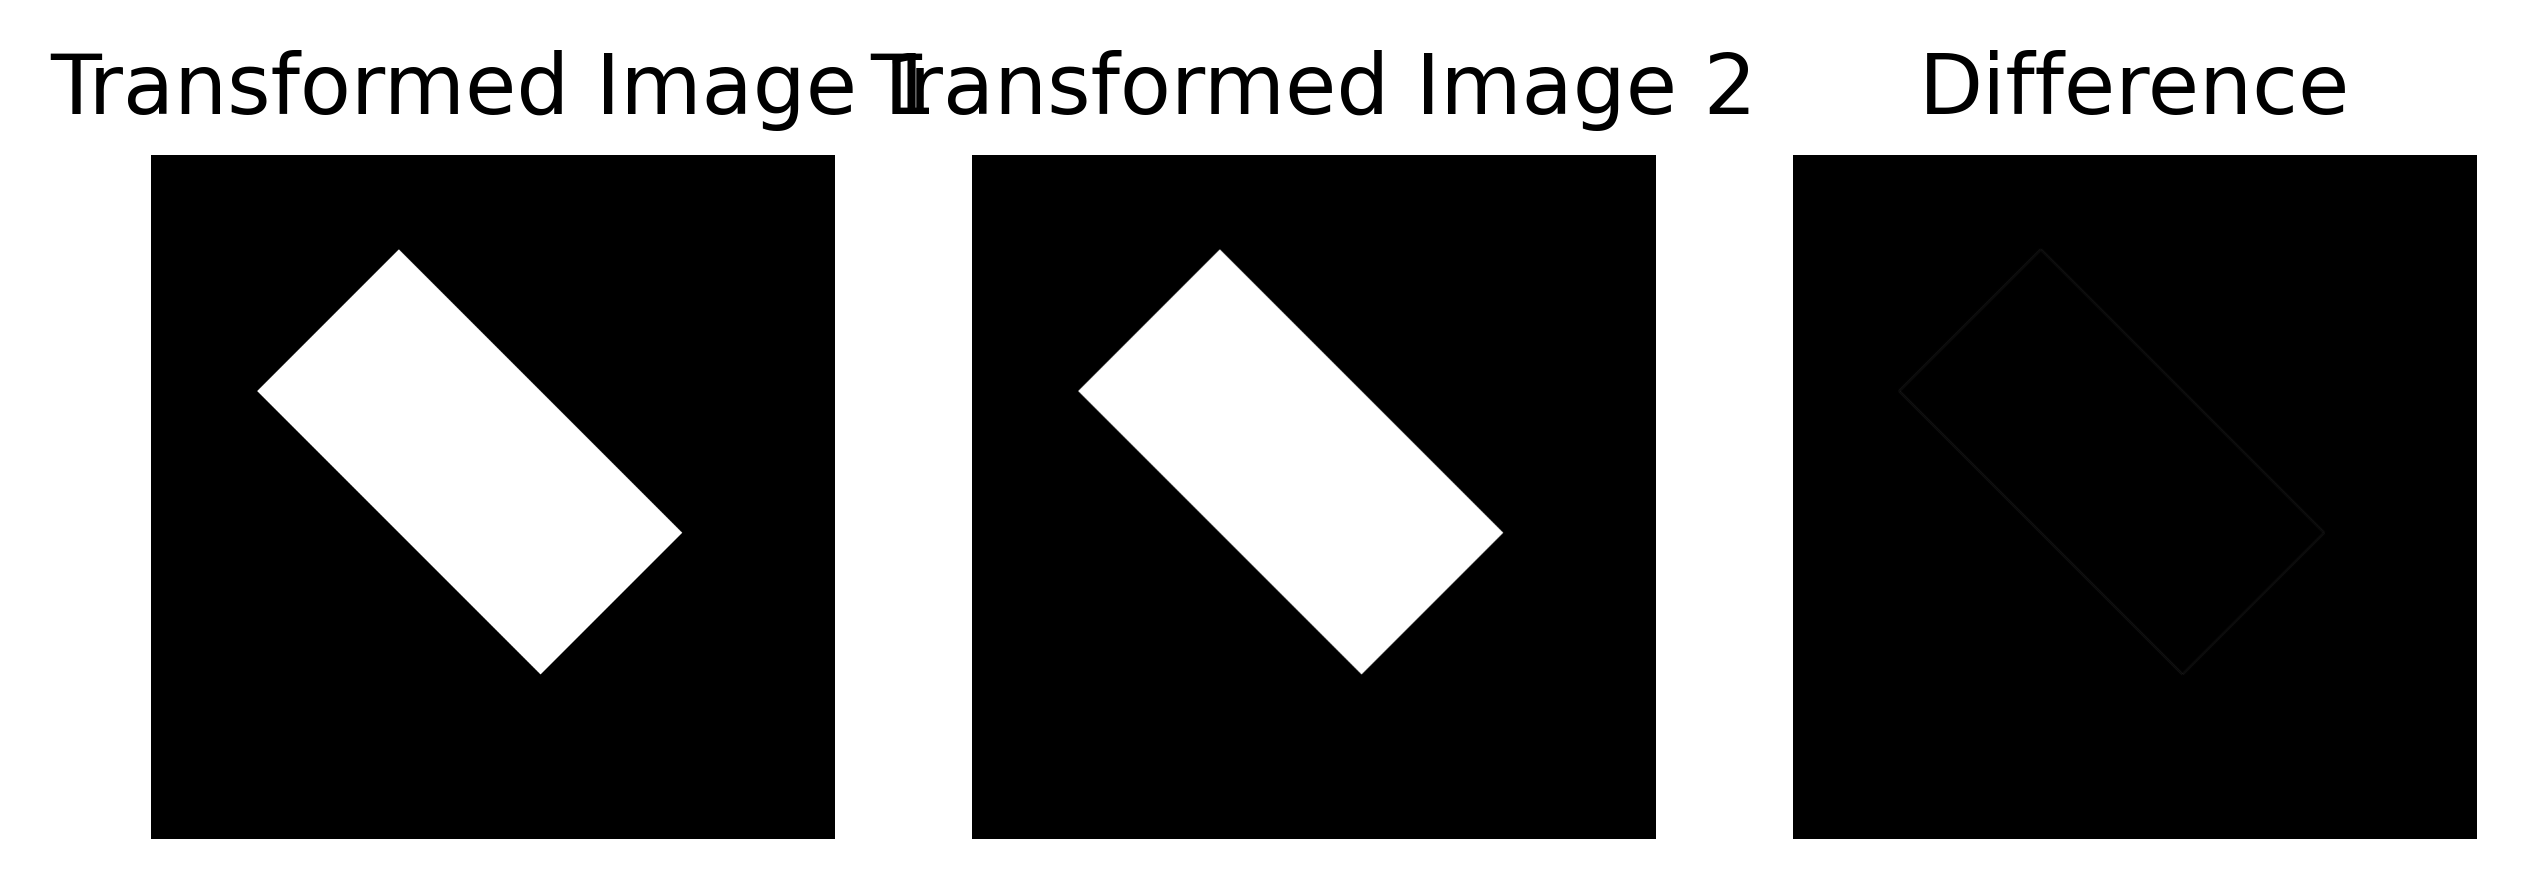

In [40]:
transformed_image = rigid_transform(image, rigid_matrix)
transformed_image_my_interpolation = rigid_transform_my_interpolation(image, rigid_matrix)
plt.figure(dpi=250)
plt.subplot(1, 3, 1)
plt.imshow(transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image 1")
plt.subplot(1, 3, 2)
plt.imshow(transformed_image_my_interpolation, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image 2")
plt.subplot(1, 3, 3)
plt.imshow(np.abs(transformed_image - transformed_image_my_interpolation), cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Difference")
plt.show()

Ostatnim zadaniem jest implementacja funkcji do transformacji lokalnej (0.5p). Zaimplementuj funkcję (wykorzystaj własną funkcję do interpolacji) i wygeneruj losowe pole przemieszczeń, np:

In [45]:
def local_transform(image, u_x, u_y):
    """
    image - obraz do transformacji (YxX)
    u_x - pole przemieszczeń po kolumnach (YxX)
    u_y - pole przemieszczeń po wierszach (YxX)
    """
    row,col = np.shape(image)

    local_trans = np.zeros(np.shape(image))
    
    gridX, gridY = np.array(np.meshgrid(np.arange(0,row,1),np.arange(0,col,1)))
    gridX = gridX+ u_x
    gridY = gridY+ u_y
    
    local_trans = interpolate_2d(image,gridX,gridY)
    return local_trans

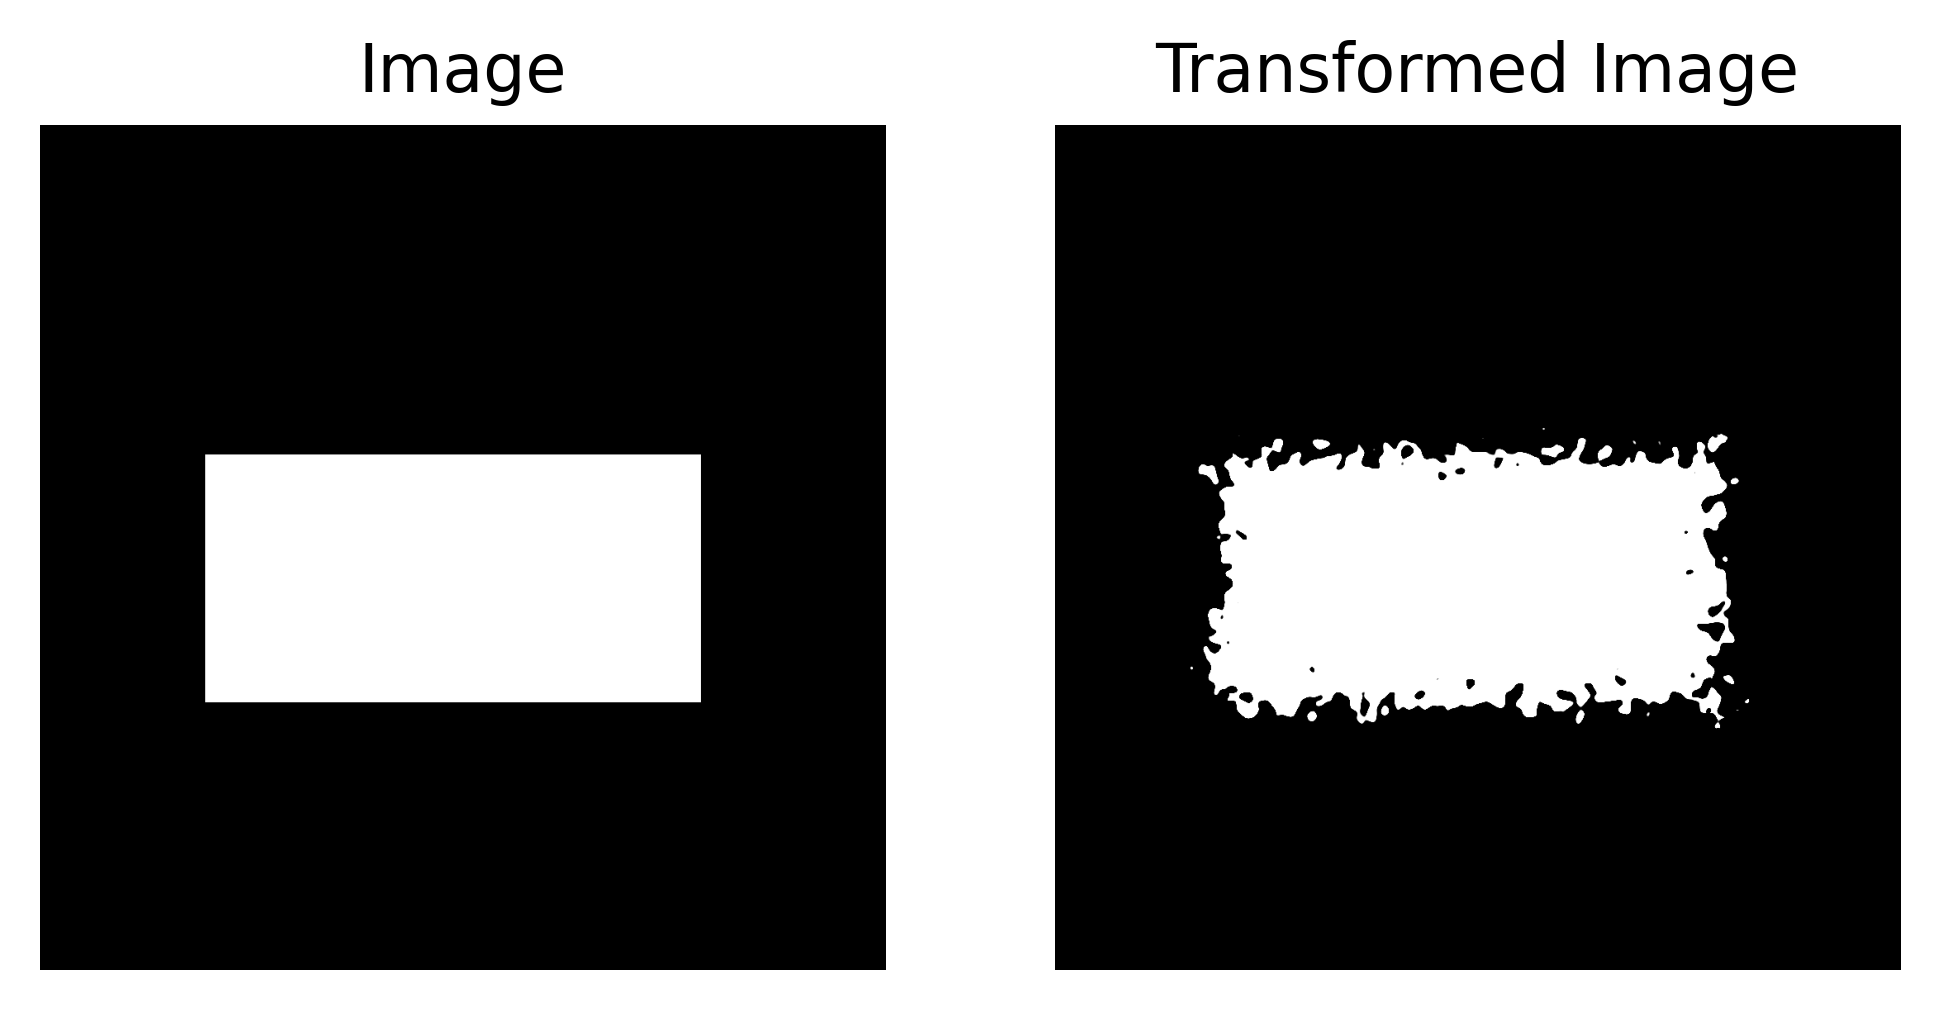

In [46]:
np.random.seed(5)
u_x, u_y = np.random.randn(y_size, x_size)*250, np.random.randn(y_size, x_size)*250
u_x, u_y = nd.gaussian_filter(u_x, 5), nd.gaussian_filter(u_y, 5)
nonrigid_transformed_image = local_transform(image, u_x, u_y)
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(nonrigid_transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image")
plt.show()
